# Graph-based Model
Our novel idea is to construct a graph-structured model to detect frauds from the provider - beneficiaries connection.
In our graph-structured dataset, we have:
- Relationships from Provider to Beneficiaries
- Relationships from Provider to Physician

Both graphs will have the edge weights equal to the number of claims

In [2]:
# Import libraries
import warnings

warnings.filterwarnings("ignore") # To hide deprecation warnings arising from underlying function calls made by featuretools

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 500)

### 8.1 Import Preprocessed Datasets 

We will only take the relevant columns to be used as nodes: Provider, Beneficiary and Physician.

The edges and its weight will represent the number of claims/rows that each pair of Provider-Beneficiary or Provider-Physician appears in our dataset.

In [18]:
# Load preprocessed datasets
X_train1 = pd.read_csv('X_train1.csv')
X_train2 = pd.read_csv('X_train2.csv')
y_labels = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
X_labeled = pd.concat([X_train1, X_train2], ignore_index=True) # Combine into 1 training set
# only take our relevant columns as nodes columns
X_nodes = X_labeled[['Provider','BeneID', 'AttendingPhysician_ce', 'OperatingPhysician_ce', 'OtherPhysician_ce']]

# As labels were provided for fraudulent providers only, we will retain the providers in our y_labels only.
y_providers = y_labels[['Provider', 'PotentialFraud']].drop_duplicates(ignore_index=True)


In [90]:
# Construct our 2 datasets for our 2 graphs
# Graph 1: Provider - Beneficiaries
X_provider_bene_edgelists = X_nodes.groupby(['Provider', 'BeneID']).size().reset_index(name='Count')
X_provider_bene_edgelists['EdgeKey'] = 'Bene'
# Graph 2: Provider - Physicians
X_nodes_provider_physician = X_nodes[['Provider', 'AttendingPhysician_ce', 'OperatingPhysician_ce', 'OtherPhysician_ce']]
# melt the DataFrame, combining all 3 physician codes into 1
X_provider_physician_melt = pd.melt(X_nodes_provider_physician, id_vars=['Provider'], value_name='Physician')
# drop the variable name column and 0 value
X_provider_physician_melt = X_provider_physician_melt[X_provider_physician_melt['Physician'] != 0]
X_provider_physician_edgelists = X_provider_physician_melt.groupby(['Provider', 'Physician']).size().reset_index(name='Count')
X_provider_physician_edgelists['EdgeKey'] = 'Phys'

In [91]:
display(X_provider_bene_edgelists.head(2))
display(X_provider_physician_edgelists.head(2))

,Provider,BeneID,Count,EdgeKey
0,PRV51001,BENE102690,1,Bene
1,PRV51001,BENE106078,1,Bene


,Provider,Physician,Count,EdgeKey
0,PRV51001,1.0,9,Phys
1,PRV51001,2.0,8,Phys


{('PRV51017',
  'BENE147971'): Text(-0.2778247814016882, 0.2766408755785924, '1'),
 ('PRV55490',
  'BENE102388'): Text(0.8550863280041318, -0.30852660391483455, '1'),
 ('PRV56689',
  'BENE93776'): Text(-0.12330716731311428, -0.906743158900905, '1'),
 ('PRV55039', 'BENE99979'): Text(0.4442293330524246, 0.6855853026969888, '1'),
 ('PRV55039', 'BENE156638'): Text(0.4690310518277132, 0.7141164083197827, '6'),
 ('PRV55163',
  'BENE153540'): Text(-0.8173927981822056, -0.5055545972089941, '1'),
 ('PRV53121',
  'BENE104195'): Text(-0.2263477080137585, -0.9390125338290725, '2'),
 ('PRV51954',
  'BENE109627'): Text(-0.9284433883176704, 0.4929804726931425, '1'),
 ('PRV54887',
  'BENE20564'): Text(-0.6779551356707756, -0.6698994631658988, '1'),
 ('PRV51176',
  'BENE63724'): Text(-0.8707108385324804, 0.11848584495024175, '1'),
 ('PRV51176',
  'BENE55057'): Text(-0.8379734705175065, 0.11857230921300016, '1'),
 ('PRV56733',
  'BENE38450'): Text(-0.18710091240714477, 0.6254410791385439, '1'),
 ('PRV52

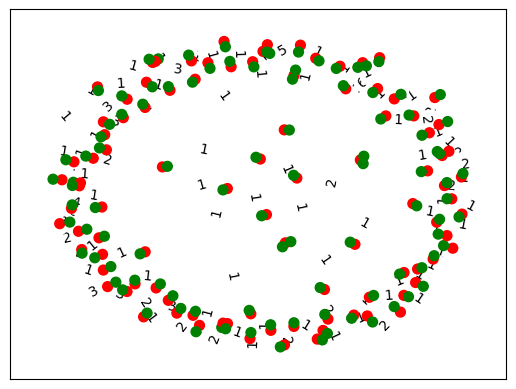

In [92]:
# Graph 0 - Subgraph of the data for visualisation
df_plotting = X_provider_bene_edgelists.sample(n=100, random_state=1)
H = nx.from_pandas_edgelist(df_plotting, source='Provider', target = 'BeneID', edge_attr="Count")
color_map = ['red' if node.startswith('PRV') else 'green' for node in H] 
nx.draw_networkx(H, pos=nx.spring_layout(H), with_labels=False, node_color=color_map, node_size=50)
nx.draw_networkx_edge_labels(H,pos=nx.spring_layout(H),edge_labels=nx.get_edge_attributes(H,'Count'))

In [124]:
# Graph 1 - Relationships between Provider and Beneficiaries
G_1 = nx.from_pandas_edgelist(X_provider_bene_edgelists, source='Provider', target = 'BeneID', 
                            edge_attr="Count", create_using=nx.DiGraph())

# Graph 2 - Relationships between Provider and Physicians
G_2 = nx.from_pandas_edgelist(X_provider_physician_edgelists, source='Provider', target = 'Physician',
                            edge_attr="Count", create_using=nx.DiGraph())

In [95]:
# combine graphs
G_combined = nx.compose(G_1, G_2)

### 8.2 Approach with Graph-structured Data
We have 2 approaches to handle this graph-structured data:

Approach 1: Use GNN Models for Clustering Detection and Provider Node Classification (on the combine MultiDiGraph G_combined)

Approach 2: On the Provider-Beneficiary Graph G_1 and Provider-Physician Graph G_2, extract useful metrics for Provider Node:
- Degree of the nodes
- Closeness Centrality Coefficient
- Eigenvector Centrality
- PageRank
which can be used as featured in our conventional machine learning algoritms

#### Approach 1: Applying GNN for Node Classification

In [106]:
import torch
from torch_geometric.transforms import NormalizeFeatures

In [102]:
# Import relevant libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

#### Approach 2: Extracting useful Graph Metrics Features

In [161]:
provider_graph_features = y_providers.copy()

In [163]:
# defining a dictionary of graph features
graph_features_dict = {
    'degree': lambda x : dict(x.degree(weight="Count")),
    # 'closeness_centrality': lambda x : nx.closeness_centrality(x), NOT calculated as it it not a connected graph
    'eigenvector_centrality': lambda x : nx.eigenvector_centrality_numpy(x, weight="Count"),
    'pagerank': lambda x : nx.pagerank(x, weight="Count")
}

# computing graph features for each Provider node in G_1: Provider - Beneficiary
graph_features = pd.DataFrame()
graph_features_2 = pd.DataFrame()
for info, func in graph_features_dict.items():
    temp_1 = pd.DataFrame.from_dict(func(G_1), orient='index').rename(columns = {0 : 'bene_' + info}).reset_index()
    if graph_features.empty:
        graph_features = temp_1
    else:
        graph_features = graph_features.merge(temp_1, on='index')
    temp_2 = pd.DataFrame.from_dict(func(G_2), orient='index').rename(columns = {0 : 'physician_' + info}).reset_index()
    if graph_features_2.empty:
        graph_features_2 = temp_2
    else:
        graph_features_2 = graph_features_2.merge(temp_2, on='index')

provider_graph_features = provider_graph_features.merge(graph_features, left_on='Provider',right_on='index', how='left').drop('index', axis=1)
provider_graph_features = provider_graph_features.merge(graph_features_2, left_on='Provider',right_on='index', how='left').drop('index', axis=1)

In [166]:
provider_graph_features

,Provider,PotentialFraud,bene_degree,bene_eigenvector_centrality,bene_pagerank,physician_degree,physician_eigenvector_centrality,physician_pagerank
0,PRV55912,1,107,3.785693e-14,0.000007,180,8.722197e-11,0.000096
1,PRV55907,0,243,-8.226661e-15,0.000007,374,1.955750e-11,0.000096
2,PRV56046,0,20,-7.158579e-14,0.000007,34,-5.158638e-11,0.000096
3,PRV52405,0,89,-3.655540e-14,0.000007,144,-2.854321e-11,0.000096
4,PRV56614,0,26,9.413253e-14,0.000007,45,-6.363547e-11,0.000096
...,...,...,...,...,...,...,...,...
5405,PRV54302,0,1,-7.932577e-14,0.000007,2,3.389878e-11,0.000096
5406,PRV57762,0,1,-9.432569e-14,0.000007,1,7.996262e-11,0.000096
5407,PRV51577,0,1,-1.259187e-14,0.000007,1,6.466995e-11,0.000096
5408,PRV53083,0,1,-7.823344e-15,0.000007,1,1.790824e-11,0.000096


<Axes: >

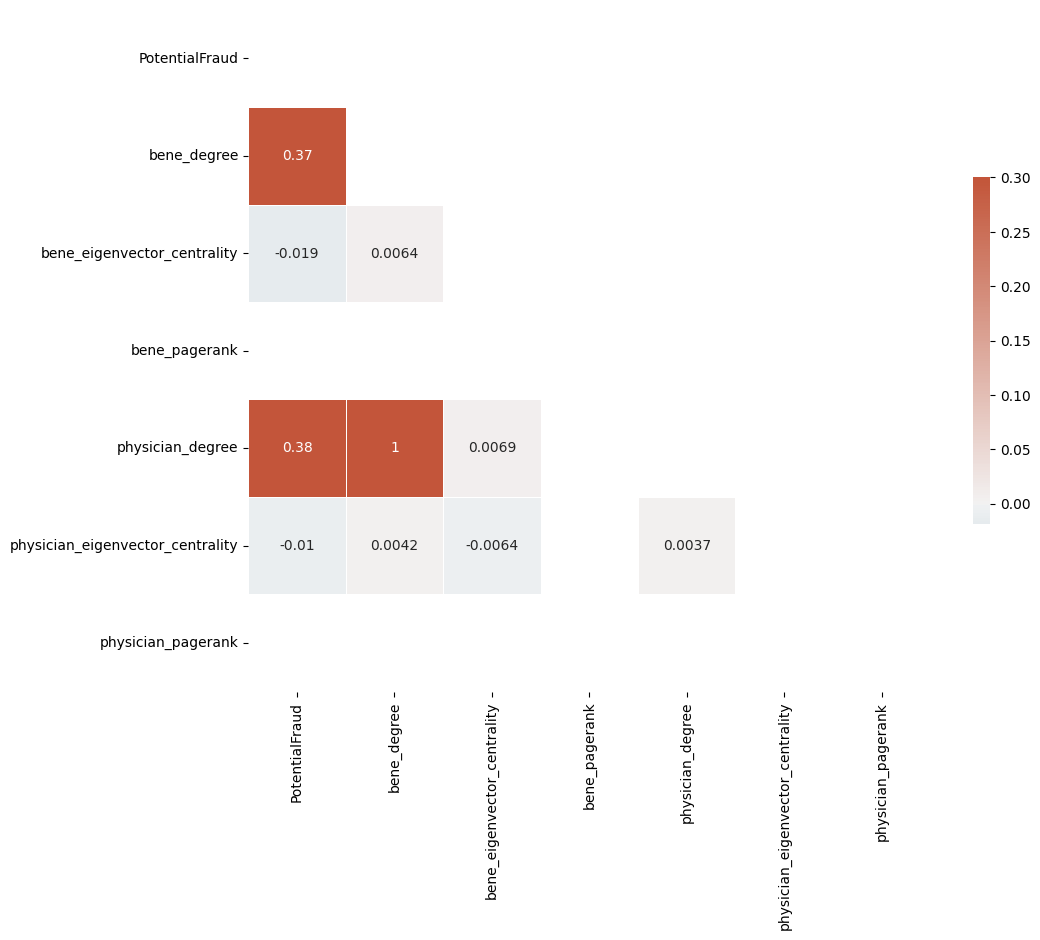

In [167]:
corr_data = provider_graph_features[['PotentialFraud',
                'bene_degree',
#                 'Provider_closeness_centrality',
                'bene_eigenvector_centrality',
                'bene_pagerank',
                'physician_degree',
#                 'physician_closeness_centrality',
                'physician_eigenvector_centrality',
                'physician_pagerank']]

# Compute the correlation matrix
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [155]:
dict(G_1.degree(weight="Count"))

{'PRV51001': 25,
 'BENE102690': 11,
 'BENE106078': 2,
 'BENE11727': 5,
 'BENE123416': 4,
 'BENE126477': 6,
 'BENE130029': 5,
 'BENE134788': 3,
 'BENE137197': 9,
 'BENE146687': 12,
 'BENE152088': 5,
 'BENE156020': 8,
 'BENE24646': 2,
 'BENE31617': 3,
 'BENE32715': 21,
 'BENE36012': 3,
 'BENE38773': 6,
 'BENE49220': 3,
 'BENE56354': 3,
 'BENE57060': 3,
 'BENE61975': 8,
 'BENE79474': 16,
 'BENE81544': 3,
 'BENE86784': 5,
 'BENE98831': 1,
 'PRV51003': 132,
 'BENE102788': 7,
 'BENE103188': 2,
 'BENE103642': 1,
 'BENE104048': 2,
 'BENE104089': 7,
 'BENE104872': 7,
 'BENE109269': 5,
 'BENE110642': 3,
 'BENE111036': 7,
 'BENE111312': 2,
 'BENE112437': 6,
 'BENE11305': 13,
 'BENE113706': 3,
 'BENE116643': 7,
 'BENE118066': 2,
 'BENE120443': 3,
 'BENE123584': 1,
 'BENE123864': 5,
 'BENE125315': 7,
 'BENE12706': 6,
 'BENE127457': 4,
 'BENE129813': 9,
 'BENE130087': 1,
 'BENE130167': 1,
 'BENE131164': 1,
 'BENE131498': 3,
 'BENE131775': 10,
 'BENE132954': 6,
 'BENE133762': 1,
 'BENE134312': 9,
 'B

In [3]:
gss = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=4012)
split = gss.split(X_full, groups=X_full.Provider)
train_ix, test_ix = next(split)

X_train = X_full.loc[train_ix]
X_val = X_full.loc[test_ix]

providers_train = X_train.Provider.unique()
providers_val = X_val.Provider.unique()
y_train = y_providers[y_providers.Provider.isin(providers_train)]
y_val = y_providers[y_providers.Provider.isin(providers_val)]

In [4]:
# View X_train
display(X_train.head())
print(X_train.shape)

,AdmitForDays,Age,AttendingPhysician_ce,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimID,ClaimProcessedForDays,ClmAdmitDiagnosisCode_ce,ClmDiagnosisCode_10_ce,ClmDiagnosisCode_1_ce,ClmDiagnosisCode_2_ce,ClmDiagnosisCode_3_ce,ClmDiagnosisCode_4_ce,ClmDiagnosisCode_5_ce,ClmDiagnosisCode_6_ce,ClmDiagnosisCode_7_ce,ClmDiagnosisCode_8_ce,ClmDiagnosisCode_9_ce,ClmProcedureCode_1_ce,ClmProcedureCode_2_ce,ClmProcedureCode_3_ce,ClmProcedureCode_4_ce,ClmProcedureCode_5_ce,County,DeductibleAmtPaid,DiagnosisGroupCode_ce,Gender,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,InscClaimAmtReimbursed,NoOfMonths_PartACov,NoOfMonths_PartBCov,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OperatingPhysician_ce,OtherPhysician_ce,Provider,Race,RenalDiseaseIndicator,State,isDead,is_inpatient
1,3.0,67.0,3.0,1,0,1,1,0,1,1,0,0,1,1,CLM66048,3,57.0,0.0,57.0,5182.0,3461.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,230,1068.0,16,1,3204,36000,5000,12,12,70,60,3.0,0.0,PRV55907,1,0,39,0.0,1
2,4.0,67.0,12.0,1,0,1,1,0,1,1,0,0,1,1,CLM68358,4,1041.0,0.0,170.0,550.0,3416.0,2177.0,836.0,2242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,160,1,3204,36000,5000,12,12,70,60,0.0,14.0,PRV56046,1,0,39,0.0,1
3,9.0,96.0,55.0,0,0,1,1,1,0,1,0,0,1,1,CLM38412,9,360.0,0.0,2077.0,1423.0,630.0,2242.0,163.0,2941.0,412.0,5427.0,79788.0,100.0,0.0,0.0,0.0,0.0,360,1068.0,38,2,1068,5000,5000,12,12,320,250,12.0,15.0,PRV52405,2,0,1,0.0,1
6,6.0,70.0,8.0,1,1,0,0,1,1,0,0,1,1,0,CLM32075,6,173.0,0.0,185.0,7534.0,652.0,1290.0,13398.0,79788.0,5182.0,8333.0,4499.0,82.0,0.0,0.0,0.0,0.0,120,1068.0,64,1,1068,8000,8000,12,12,50,860,4.0,0.0,PRV54090,2,0,24,0.0,1
7,5.0,68.0,5.0,0,0,0,1,0,1,0,0,1,0,0,CLM62376,5,7304.0,0.0,327.0,39724.0,4984.0,7534.0,1009.0,15171.0,2197.0,4499.0,15246.0,1152.0,0.0,0.0,0.0,0.0,230,1068.0,79,1,1068,6000,6000,12,12,0,0,19.0,0.0,PRV51148,1,0,38,0.0,1


(447666, 51)


In [5]:
# View y_train
display(y_train.head())
print(y_train.shape)

,Provider,PotentialFraud
1,PRV55907,0
2,PRV56046,0
3,PRV52405,0
6,PRV54090,0
7,PRV51148,1


(4328, 2)


In [6]:
# View X_val
display(X_val.head())
print(X_val.shape)

,AdmitForDays,Age,AttendingPhysician_ce,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimID,ClaimProcessedForDays,ClmAdmitDiagnosisCode_ce,ClmDiagnosisCode_10_ce,ClmDiagnosisCode_1_ce,ClmDiagnosisCode_2_ce,ClmDiagnosisCode_3_ce,ClmDiagnosisCode_4_ce,ClmDiagnosisCode_5_ce,ClmDiagnosisCode_6_ce,ClmDiagnosisCode_7_ce,ClmDiagnosisCode_8_ce,ClmDiagnosisCode_9_ce,ClmProcedureCode_1_ce,ClmProcedureCode_2_ce,ClmProcedureCode_3_ce,ClmProcedureCode_4_ce,ClmProcedureCode_5_ce,County,DeductibleAmtPaid,DiagnosisGroupCode_ce,Gender,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,InscClaimAmtReimbursed,NoOfMonths_PartACov,NoOfMonths_PartBCov,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OperatingPhysician_ce,OtherPhysician_ce,Provider,Race,RenalDiseaseIndicator,State,isDead,is_inpatient
0,7.0,67.0,1.0,1,0,1,1,0,1,1,0,0,1,1,CLM46614,7,955.0,0.0,748.0,79788.0,4251.0,630.0,4673.0,6980.0,37270.0,341.0,5266.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,129,1,3204,36000,26000,12,12,70,60,0.0,0.0,PRV55912,1,0,39,0.0,1
4,18.0,72.0,2.0,0,0,1,0,1,1,1,1,0,0,0,CLM63689,18,1937.0,0.0,680.0,9099.0,292.0,5384.0,2765.0,6242.0,2442.0,580.0,831.0,854.0,0.0,0.0,0.0,0.0,780,1068.0,5,2,2136,21260,10000,12,12,100,120,5.0,0.0,PRV56614,1,1,45,0.0,1
5,7.0,70.0,50.0,1,1,0,1,1,1,1,1,0,1,1,CLM70950,7,1915.0,0.0,405.0,768.0,2275.0,10181.0,158.0,203.0,5182.0,39724.0,3085.0,13.0,0.0,0.0,0.0,0.0,270,1068.0,35,2,2136,22000,8000,12,12,840,1400,50.0,50.0,PRV54986,1,0,31,0.0,1
10,9.0,64.0,31.0,1,0,1,1,1,1,1,1,0,1,1,CLM57949,9,7304.0,0.0,200.0,296.0,501.0,1423.0,5266.0,12185.0,805.0,868.0,2574.0,307.0,0.0,0.0,0.0,0.0,760,1068.0,90,2,2136,131140,102000,12,12,80,1650,23.0,0.0,PRV55193,1,0,34,0.0,1
13,6.0,87.0,19.0,0,0,1,1,1,1,1,1,0,1,0,CLM54944,6,3790.0,0.0,3790.0,1143.0,4603.0,3416.0,7938.0,15171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150,1068.0,153,2,2136,23000,6000,12,12,370,620,0.0,0.0,PRV52283,1,0,10,0.0,1


(110545, 51)


In [7]:
# View y_val
display(y_val.head())
print(y_val.shape)

,Provider,PotentialFraud
0,PRV55912,1
4,PRV56614,0
5,PRV54986,1
10,PRV55193,1
13,PRV52283,1


(1082, 2)


### 6.3 Data Scaling
Now that we have our train and validation set, we will proceed to scale our data using MinMax scaling.

In [8]:
# Initiate a Scaler
minmaxScaler = MinMaxScaler()

# Fit the scaler on train data
cols_to_scale = X_train.columns.difference(['ClaimID', 'Provider'])
minmaxScaler.fit(X_train[cols_to_scale])

# Transform train and test data
X_train[cols_to_scale] = minmaxScaler.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = minmaxScaler.transform(X_val[cols_to_scale])

### 6.4 Creation of EntitySets
Next, we add our datasets into an entityset and map out their relationships. An EntitySet is a collection of dataframes and the relationship between each dataframe.

**Note**: As we have a mixture of numerical, categorical and boolean data, we will need to explicitly list the categorical and boolean data so that the appropriate operations can be performed on them during DFS.

In [9]:
# During the preprocessing stage, these are the list of numerical, categorical and boolean data
numerical_cols = [
    "AdmitForDays",
    "Age",
    "ClaimProcessedForDays",
    "DeductibleAmtPaid",
    "IPAnnualDeductibleAmt",
    "IPAnnualReimbursementAmt",
    "InscClaimAmtReimbursed",
    "NoOfMonths_PartACov",
    "NoOfMonths_PartBCov",
    "OPAnnualDeductibleAmt",
    "OPAnnualReimbursementAmt",
]
categorical_cols = [
    "AttendingPhysician_ce",
    "ClaimID",
    "ClmAdmitDiagnosisCode_ce",
    "ClmDiagnosisCode_10_ce",
    "ClmDiagnosisCode_1_ce",
    "ClmDiagnosisCode_2_ce",
    "ClmDiagnosisCode_3_ce",
    "ClmDiagnosisCode_4_ce",
    "ClmDiagnosisCode_5_ce",
    "ClmDiagnosisCode_6_ce",
    "ClmDiagnosisCode_7_ce",
    "ClmDiagnosisCode_8_ce",
    "ClmDiagnosisCode_9_ce",
    "ClmProcedureCode_1_ce",
    "ClmProcedureCode_2_ce",
    "ClmProcedureCode_3_ce",
    "ClmProcedureCode_4_ce",
    "ClmProcedureCode_5_ce",
    "County",
    "DiagnosisGroupCode_ce",
    "Gender",
    "OperatingPhysician_ce",
    "OtherPhysician_ce",
    "Provider",
    "Race",
    "State",
]
bool_cols = [
    "ChronicCond_Alzheimer",
    "ChronicCond_Cancer",
    "ChronicCond_Depression",
    "ChronicCond_Diabetes",
    "ChronicCond_Heartfailure",
    "ChronicCond_IschemicHeart",
    "ChronicCond_KidneyDisease",
    "ChronicCond_ObstrPulmonary",
    "ChronicCond_Osteoporasis",
    "ChronicCond_rheumatoidarthritis",
    "ChronicCond_stroke",
    "RenalDiseaseIndicator",
    "isDead",
    "is_inpatient",
    "RenalDiseaseIndicator",
]

In [10]:
# We will create a dictionary mapping for labelling the categorical and boolean data according to featuretools' documentation.
X_cat_bool_mapping = {
    cat_col: Categorical for cat_col in categorical_cols
}
X_cat_bool_mapping.update({
    bool_col: Boolean for bool_col in bool_cols
})

X_cat_bool_mapping

{'AttendingPhysician_ce': Categorical,
 'ClaimID': Categorical,
 'ClmAdmitDiagnosisCode_ce': Categorical,
 'ClmDiagnosisCode_10_ce': Categorical,
 'ClmDiagnosisCode_1_ce': Categorical,
 'ClmDiagnosisCode_2_ce': Categorical,
 'ClmDiagnosisCode_3_ce': Categorical,
 'ClmDiagnosisCode_4_ce': Categorical,
 'ClmDiagnosisCode_5_ce': Categorical,
 'ClmDiagnosisCode_6_ce': Categorical,
 'ClmDiagnosisCode_7_ce': Categorical,
 'ClmDiagnosisCode_8_ce': Categorical,
 'ClmDiagnosisCode_9_ce': Categorical,
 'ClmProcedureCode_1_ce': Categorical,
 'ClmProcedureCode_2_ce': Categorical,
 'ClmProcedureCode_3_ce': Categorical,
 'ClmProcedureCode_4_ce': Categorical,
 'ClmProcedureCode_5_ce': Categorical,
 'County': Categorical,
 'DiagnosisGroupCode_ce': Categorical,
 'Gender': Categorical,
 'OperatingPhysician_ce': Categorical,
 'OtherPhysician_ce': Categorical,
 'Provider': Categorical,
 'Race': Categorical,
 'State': Categorical,
 'ChronicCond_Alzheimer': Boolean,
 'ChronicCond_Cancer': Boolean,
 'Chronic

In [11]:
y_cat_bool_mapping = {
    'Provider' : Categorical,
    'PotentialFraud': Boolean
}
y_cat_bool_mapping

{'Provider': Categorical, 'PotentialFraud': Boolean}

In [12]:
# Each dataset added into the entityset requires an index column that can uniquely identify every row.
# Hence we will first find a column to use as index in X_full
print(X_train.nunique().sort_values(
    ascending=False).head())  # We will use ClaimID

ClaimID                     447666
Provider                      4328
IPAnnualReimbursementAmt      2973
OPAnnualReimbursementAmt      2066
ClmDiagnosisCode_1_ce          948
dtype: int64


In [13]:
# Add data to entityset
entityset_train = ft.EntitySet(id="train")
entityset_train = entityset_train.add_dataframe(
    dataframe=X_train, dataframe_name="X", index="ClaimID",
    logical_types=X_cat_bool_mapping
)
entityset_train = entityset_train.add_dataframe(
    dataframe=y_train, dataframe_name="y", index="Provider",
    logical_types=y_cat_bool_mapping
)

entityset_val = ft.EntitySet(id="val")
entityset_val = entityset_val.add_dataframe(
    dataframe=X_val, dataframe_name="X", index="ClaimID",
    logical_types=X_cat_bool_mapping
)
entityset_val = entityset_val.add_dataframe(
    dataframe=y_val, dataframe_name="y", index="Provider",
    logical_types=y_cat_bool_mapping
)

display(entityset_train)
display(entityset_val)

Entityset: train
  DataFrames:
    X [Rows: 447666, Columns: 51]
    y [Rows: 4328, Columns: 2]
  Relationships:
    No relationships

Entityset: val
  DataFrames:
    X [Rows: 110545, Columns: 51]
    y [Rows: 1082, Columns: 2]
  Relationships:
    No relationships

In [14]:
# Next we outline the relationships between our dataframes
entityset_train = entityset_train.add_relationship(
    parent_dataframe_name='y',
    parent_column_name='Provider',
    child_dataframe_name='X',
    child_column_name='Provider'
)

entityset_val = entityset_val.add_relationship(
    parent_dataframe_name='y',
    parent_column_name='Provider',
    child_dataframe_name='X',
    child_column_name='Provider'
)

display(entityset_train)
display(entityset_val)

Entityset: train
  DataFrames:
    X [Rows: 447666, Columns: 51]
    y [Rows: 4328, Columns: 2]
  Relationships:
    X.Provider -> y.Provider

Entityset: val
  DataFrames:
    X [Rows: 110545, Columns: 51]
    y [Rows: 1082, Columns: 2]
  Relationships:
    X.Provider -> y.Provider

### 6.5 Deep Feature Synthesis
Now that we have our entitysets, we will carry out deep feature synthesis on the training and validation data. 

In [15]:
# Now we run deep feature synthesis and create a feature matrix for each provider.
feature_matrix_providers_train, feature_defs_train = ft.dfs(
    entityset=entityset_train, target_dataframe_name="y")
feature_matrix_providers_val, feature_defs_val = ft.dfs(
    entityset=entityset_val, target_dataframe_name="y")

display(feature_matrix_providers_train.head())
print(feature_matrix_providers_train.shape)
display(feature_matrix_providers_val.head())
print(feature_matrix_providers_val.shape)

,PotentialFraud,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.ClmProcedureCode_4_ce),MODE(X.ClmProcedureCode_5_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV55907,False,243,0.805556,0.973333,0.777778,1.0,0.135974,0.476190,0.256,1.0,1

(4328, 130)


,PotentialFraud,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.ClmProcedureCode_4_ce),MODE(X.ClmProcedureCode_5_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV55912,True,107,0.777778,1.000000,0.750000,1.0,0.188232,0.475010,0.416,1.0,1.

(1082, 130)


### Dimensionality Reduction -- Principal Component Analysis

KIV: can include gridsearch/ kfold validation here to determine best number of PCA

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA with 3 components on the standard scaled dataset
pca = PCA(n_components=10, random_state=0)
pca.fit(X_train_standard_scaled[features_to_scale])

# Create a DataFrame to store the PCA results
PCA_ds = pd.DataFrame(pca.transform(X_train_standard_scaled[features_to_scale]), 
                      columns=["col1", "col2", "col3","col4","col5",'col6','col7','col8','col9','col10'])

# Display summary statistics of the PCA results
PCA_summary = PCA_ds.describe().T
print(PCA_summary)

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot for Standard Scaler')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Ideal PC = 2 for standard scaler

In [ ]:
# Perform PCA with 3 components on the minmax scaled dataset
pca_minmax = PCA(n_components=10, random_state=0)
pca_minmax.fit(X_train_minmax_scaled[features_to_scale])

# Create a DataFrame to store the PCA results
PCA_ds = pd.DataFrame(pca_minmax.transform(X_train_minmax_scaled[features_to_scale]), 
                      columns=["col1", "col2", "col3","col4","col5",'col6','col7','col8','col9','col10'])

# Display summary statistics of the PCA results
PCA_summary = PCA_ds.describe().T
print(PCA_summary)

In [ ]:
PC_values = np.arange(pca_minmax.n_components_) + 1
plt.plot(PC_values, pca_minmax.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot for Min Max Scaler')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Ideal PC = 4